# Time Series Forecasting to Predict User Data Consumption
---

In this project, we are going to use different time series forecasting models to predict a user's data consumption. The first part of the project involves simulating the data for different user types. 

In the second half, we are going to use the simulated data to model a TSF solution that will conform to the user data consumption as specified in the simulated data.

## Importing Necessary Modules
--- 

In [1]:
import os
import glob
import datetime
from math import sqrt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

%matplotlib inline

### Specifying User Types
---

In [58]:
# classification of users based on amount of data consumed per day
FREE_USER = 0  # 0 to 15
SMALL_USER = 1  # 16 to 50
MID_TIER_USER = 2  # 51 to 100
ENTERPRISE_USER = 3  # 100 and above

# classification of user type based on real world usage of SaaS platform
ECOMMERCE_STORE = 0
DATA_SCIENCE_FIRM = 1
SOFTWARE_DEVELOPER = 2

## Data Simulation 
---

In this section, we are going to work on the data simulation script. 
The first step is to define some util functions that will help us generate and manipulate data.

#### Data Generation Utils
--- 

In [94]:
def generate_date(start_date, periods):
    """Function to generate dates in a time range.
    
    Args-
        start_date: Starting date in the range 
        period: Number of instances
    
    Returns-
        date_range: Array of dates in a time range
    """
    date_range = pd.date_range(start=start_date, periods=periods)
    return date_range

In [61]:
date = generate_date("2021-01-01", 365)
date

DatetimeIndex(['2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04',
               '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
               '2021-01-09', '2021-01-10',
               ...
               '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25',
               '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', length=365, freq='D')

In [62]:
def get_weekend_index_arr(date_arr):
    """Function to get index of weekends (Sat/Sun) in a datetime array.

    Args-
        date_arr: Datetime array

    Returns-
        weekend_index_arr: array of indexes which denote weekend in datetime array
    """
    weekend_index_arr = []
    for i in range(len(date_arr)):
        weekday = date_arr[i].weekday()
        if weekday in [5, 6]:
            weekend_index_arr.append(i)
    return weekend_index_arr        

In [63]:
weekend_index_arr = get_weekend_index_arr(date)
print(weekend_index_arr)

[1, 2, 8, 9, 15, 16, 22, 23, 29, 30, 36, 37, 43, 44, 50, 51, 57, 58, 64, 65, 71, 72, 78, 79, 85, 86, 92, 93, 99, 100, 106, 107, 113, 114, 120, 121, 127, 128, 134, 135, 141, 142, 148, 149, 155, 156, 162, 163, 169, 170, 176, 177, 183, 184, 190, 191, 197, 198, 204, 205, 211, 212, 218, 219, 225, 226, 232, 233, 239, 240, 246, 247, 253, 254, 260, 261, 267, 268, 274, 275, 281, 282, 288, 289, 295, 296, 302, 303, 309, 310, 316, 317, 323, 324, 330, 331, 337, 338, 344, 345, 351, 352, 358, 359]


In [64]:
def reduce_data_consumption_on_weekend(data, weekend_index_arr):
    """Function to simulate lower data usage on weekends.

    Args-
        data: Array for data consumption on each day
        weekend_index_arr: Array of indexes denoting weekends
    
    Returns-
        data: Modified data array with reduced data on weekends
    """
    for i in weekend_index_arr:
        scale = np.random.uniform(0.6, 1)
        data[i] = scale * data[i]
    return data            

In [65]:
def reduce_data_consumption_in_date_range(data, start_date, end_date):
    """Function to simulate reduced data consumption in a date range

    Args-
        data: Array denoting data consumption per day over a period of time
        start_date: Datetime object denoting start date for low data consumption period
        end_date: Datetime object denoting start date for low data consumption period  

    Returns-
        data: Modified data array
    """
    start_day = start_date.timetuple().tm_yday - 1
    end_day = end_date.timetuple().tm_yday - 1
    for i in range(start_day, end_day): 
        scale = np.random.uniform(0.5, 1)
        data[i] = scale * data[i]
    return data  

In [66]:
def increase_data_consumption_in_date_range(data, start_date, end_date):
    """Function to simulate increased data consumption in a date range

    Args-
        data: Array denoting data consumption per day over a period of time
        start_date: Datetime object denoting start date for high data consumption period
        end_date: Datetime object denoting start date for high data consumption period  

    Returns-
        data: Modified data array
    """
    start_day = start_date.timetuple().tm_yday - 1
    end_day = end_date.timetuple().tm_yday - 1
    for i in range(start_day, end_day): 
        scale = np.random.uniform(1, 2)
        data[i] = scale * data[i]
    return data  

In [67]:
def alter_data_consumption_in_date_ranges(data, date_ranges, increase):
    """Function to modify data consumption in a list of date ranges

    Args-
        data: Array denoting data consumption over a period of time
        data_ranges: List of [start_date, end_date] combination tuple/list
        increase: Boolean denoting whether data consumption is to be increased or decreased in the period   

    Returns-
        data: Modified data array
    """
    for start_date, end_date in date_ranges:
        if increase:
            data = increase_data_consumption_in_date_range(data, start_date, end_date)
        else:
            data = reduce_data_consumption_in_date_range(data, start_date, end_date)
    return data        

In [68]:
def generate_date(date_str):
    """Function to generate datetime object from date string.
    
    Args-
        date_str: String denoting date in dd/mm/yyyy format

    Returns-
        date: Datetime object corresponding to date_str 
    """
    date = datetime.datetime.strptime(date_str, "%d/%m/%Y")
    return date 

In [69]:
# date ranges denoting weak sales period (hence, reduced data consumption)
weak_sales_period = [[generate_date("21/09/2021"), generate_date("06/10/2021")],
                     [generate_date("6/11/2021"), generate_date("15/11/2021")],
                     [generate_date("01/01/2021"), generate_date("10/01/2021")],
                     [generate_date("01/05/2021"), generate_date("05/05/2021")]]

# date ranges denoting strong sales period (hence, increased data consumption)
strong_sales_period = [[generate_date("20/01/2021"), generate_date("24/01/2021")],
                       [generate_date("01/03/2021"), generate_date("07/03/2021")],
                       [generate_date("03/07/2021"), generate_date("08/07/2021")],
                       [generate_date("28/10/2021"), generate_date("03/11/2021")],
                       [generate_date("20/11/2021"), generate_date("26/11/2021")],
                       [generate_date("20/12/2021"), generate_date("25/12/2021")]]                     

In [70]:
def get_user_type(upper_limit):
    """Function to fetch user type.
    Args-
        upper_limit: Upper limit of user's data consumption range
    Returs-
        user_type: Type of user    
    """
    if upper_limit > 100:
        return ENTERPRISE_USER
    elif 51 <= upper_limit <= 100:
        return MID_TIER_USER
    elif 16 <= upper_limit <= 50:
        return SMALL_USER     
    else:
        return FREE_USER

In [71]:
def generate_data_values(low, high, size):
    """Function to generate random values in a range.
    Args-
        low: Lower limit of the range 
        high: Upper limit of the range
        size: Number of instances
    Returns-
        data: Array of random values in the range
        user_identifier = Type of user
    """
    data = np.random.uniform(low=low, high=high, size=size)
    data = reduce_data_consumption_on_weekend(data, weekend_index_arr)
    user_type = get_user_type(high)
    user_identifier = np.ones(size, dtype=np.int8) * user_type
    return data, user_identifier

In [75]:
# generating data for different users
user1, user_type_1 = generate_data_values(120, 128, 365) 
user2, user_type_2 = generate_data_values(35, 45, 365) 
user3, user_type_3 = generate_data_values(75, 80, 365) 
user4, user_type_4 = generate_data_values(20, 25, 365) 
user5, user_type_5 = generate_data_values(10, 15, 365) 
user6, user_type_6 = generate_data_values(30, 35, 365) 
user7, user_type_7 = generate_data_values(50, 60, 365) 
user8, user_type_8 = generate_data_values(7, 12, 365) 
user9, user_type_9 = generate_data_values(60, 65, 365) 
user10, user_type_10 = generate_data_values(150, 155, 365) 

user11, user_type_11 = generate_data_values(140, 150, 365) 
user12, user_type_12 = generate_data_values(62, 67, 365) 
user13, user_type_13 = generate_data_values(33, 39, 365) 
user14, user_type_14 = generate_data_values(170,180,365) 
user15, user_type_15 = generate_data_values(6,12,365) 
user16, user_type_16 = generate_data_values(87,93,365) 
user17, user_type_17 = generate_data_values(200,210,365) 
user18, user_type_18 = generate_data_values(40,45,365) 
user19, user_type_19 = generate_data_values(60,65,365) 
user20, user_type_20 = generate_data_values(0,2,365) 

user21, user_type_21 = generate_data_values(30, 40, 365) 
user22, user_type_22 = generate_data_values(170, 180, 365) 
user23, user_type_23 = generate_data_values(25, 33, 365) 
user24, user_type_24 = generate_data_values(50, 60, 365) 
user25, user_type_25 = generate_data_values(7, 15, 365) 
user26, user_type_26 = generate_data_values(130, 135, 365) 
user27, user_type_27 = generate_data_values(40, 50, 365) 
user28, user_type_28 = generate_data_values(0, 7, 365) 
user29, user_type_29 = generate_data_values(20, 30, 365) 
user30, user_type_30 = generate_data_values(70, 80, 365) 

user31, user_type_31 = generate_data_values(5, 10, 365) 
user32, user_type_32 = generate_data_values(200, 210, 365) 
user33, user_type_33 = generate_data_values(65, 70, 365) 
user34, user_type_34 = generate_data_values(9, 14, 365) 
user35, user_type_35 = generate_data_values(39, 50, 365) 
user36, user_type_36 = generate_data_values(70, 75, 365) 
user37, user_type_37 = generate_data_values(0, 8, 365) 
user38, user_type_38 = generate_data_values(80, 90, 365) 
user39, user_type_39 = generate_data_values(250, 255, 365) 
user40, user_type_40 = generate_data_values(10, 15, 365) 

user41, user_type_41 = generate_data_values(195, 200, 365) 
user42, user_type_42 = generate_data_values(55, 65, 365) 
user43, user_type_43 = generate_data_values(275, 300, 365) 
user44, user_type_44 = generate_data_values(79, 100, 365) 
user45, user_type_45 = generate_data_values(20, 30, 365) 
user46, user_type_46 = generate_data_values(3, 9, 365) 
user47, user_type_47 = generate_data_values(150, 160, 365) 
user48, user_type_48 = generate_data_values(35, 45, 365) 
user49, user_type_49 = generate_data_values(6, 12, 365) 
user50, user_type_50 = generate_data_values(60, 65, 365)

In [72]:
def generate_user_type(value):
    """Function to generate random values in a range.
    Args-
        low: Lower limit of the range 
        high: Upper limit of the range
        size: Number of instances
    Returns-
        data: Array of random values in the range
    """
    
    user_type_range = np.random.randint(0,3)
    return user_type_range

#### Simulated Data Generation
---

With all the util functions defined, let us now generate the simulated datasets for different user types.

In [73]:
def generate_dataset(data_range, date_range, user_type, customer_id, dir, customer_type=None, decrease_period=None, increase_period=None):
    """Function to generate dataset for daily data consumption of a user.
    Args-
        data_range: Daily data consumption
        date_range: Date
        user_type: Type of user
        customer_id: Customer ID of the user
        dir: Path to data storage directory
    Returns-
        None
    """
    if customer_type == ECOMMERCE_STORE and user_type[0] == ENTERPRISE_USER:
        data_range = alter_data_consumption_in_date_ranges(data_range, decrease_period, False)
        data_range = alter_data_consumption_in_date_ranges(data_range, increase_period, True)
    dataset_df = pd.DataFrame({"date": date_range, "daily_usage": data_range, "user_type": user_type})
    path_to_file = os.path.join(dir, customer_id)
    dataset_df.to_csv(path_to_file, index=False)

In [18]:
# generating dataset for all customers
dir_path = r"D:\HPE_CTY\data"
if not os.path.exists(dir_path):
    os.mkdir(dir_path)

generate_dataset(user1, date, user_type_1, "cust01.csv", dir_path, customer_type=ECOMMERCE_STORE, decrease_period=weak_sales_period, increase_period=strong_sales_period)
generate_dataset(user2, date, user_type_2, "cust02.csv", dir_path)
generate_dataset(user3, date, user_type_3, "cust03.csv", dir_path)
generate_dataset(user4, date, user_type_4, "cust04.csv", dir_path)
generate_dataset(user5, date, user_type_5, "cust05.csv", dir_path)
generate_dataset(user6, date, user_type_6, "cust06.csv", dir_path)
generate_dataset(user7, date, user_type_7, "cust07.csv", dir_path)
generate_dataset(user8, date, user_type_8, "cust08.csv", dir_path)
generate_dataset(user9, date, user_type_9, "cust09.csv", dir_path)
generate_dataset(user10, date, user_type_10, "cust10.csv", dir_path, customer_type=ECOMMERCE_STORE, decrease_period=weak_sales_period, increase_period=strong_sales_period)

generate_dataset(user11, date, user_type_11, "cust11.csv", dir_path)
generate_dataset(user12, date, user_type_12, "cust12.csv", dir_path)
generate_dataset(user13, date, user_type_13, "cust13.csv", dir_path)
generate_dataset(user14, date, user_type_14, "cust14.csv", dir_path, customer_type=ECOMMERCE_STORE, decrease_period=weak_sales_period, increase_period=strong_sales_period)
generate_dataset(user15, date, user_type_15, "cust15.csv", dir_path)
generate_dataset(user16, date, user_type_16, "cust16.csv", dir_path)
generate_dataset(user17, date, user_type_17, "cust17.csv", dir_path, customer_type=ECOMMERCE_STORE, decrease_period=weak_sales_period, increase_period=strong_sales_period)
generate_dataset(user18, date, user_type_18, "cust18.csv", dir_path)
generate_dataset(user19, date, user_type_19, "cust19.csv", dir_path)
generate_dataset(user20, date, user_type_20, "cust20.csv", dir_path)

generate_dataset(user21, date, user_type_21, "cust21.csv", dir_path)
generate_dataset(user22, date, user_type_22, "cust22.csv", dir_path, customer_type=ECOMMERCE_STORE, decrease_period=weak_sales_period, increase_period=strong_sales_period)
generate_dataset(user23, date, user_type_23, "cust23.csv", dir_path)
generate_dataset(user24, date, user_type_24, "cust24.csv", dir_path)
generate_dataset(user25, date, user_type_25, "cust25.csv", dir_path)
generate_dataset(user26, date, user_type_26, "cust26.csv", dir_path)
generate_dataset(user27, date, user_type_27, "cust27.csv", dir_path)
generate_dataset(user28, date, user_type_28, "cust28.csv", dir_path)
generate_dataset(user29, date, user_type_29, "cust29.csv", dir_path)
generate_dataset(user30, date, user_type_30, "cust30.csv", dir_path)

generate_dataset(user31, date, user_type_31, "cust31.csv", dir_path)
generate_dataset(user32, date, user_type_32, "cust32.csv", dir_path)
generate_dataset(user33, date, user_type_33, "cust33.csv", dir_path)
generate_dataset(user34, date, user_type_34, "cust34.csv", dir_path)
generate_dataset(user35, date, user_type_35, "cust35.csv", dir_path)
generate_dataset(user36, date, user_type_36, "cust36.csv", dir_path)
generate_dataset(user37, date, user_type_37, "cust37.csv", dir_path)
generate_dataset(user38, date, user_type_38, "cust38.csv", dir_path)
generate_dataset(user39, date, user_type_39, "cust39.csv", dir_path, customer_type=ECOMMERCE_STORE, decrease_period=weak_sales_period, increase_period=strong_sales_period)
generate_dataset(user40, date, user_type_40, "cust40.csv", dir_path)

generate_dataset(user41, date, user_type_41, "cust41.csv", dir_path, customer_type=ECOMMERCE_STORE, decrease_period=weak_sales_period, increase_period=strong_sales_period)
generate_dataset(user42, date, user_type_42, "cust42.csv", dir_path)
generate_dataset(user43, date, user_type_43, "cust43.csv", dir_path)
generate_dataset(user44, date, user_type_44, "cust44.csv", dir_path, customer_type=ECOMMERCE_STORE, decrease_period=weak_sales_period, increase_period=strong_sales_period)
generate_dataset(user45, date, user_type_45, "cust45.csv", dir_path)
generate_dataset(user46, date, user_type_46, "cust46.csv", dir_path)
generate_dataset(user47, date, user_type_47, "cust47.csv", dir_path, customer_type=ECOMMERCE_STORE, decrease_period=weak_sales_period, increase_period=strong_sales_period)
generate_dataset(user48, date, user_type_48, "cust48.csv", dir_path)
generate_dataset(user49, date, user_type_49, "cust49.csv", dir_path)
generate_dataset(user50, date, user_type_50, "cust50.csv", dir_path)

#### Merging All Datasets
---

Finally let's merge all the datasets into a single CSV file. This is just for experimentation purposes.

In [19]:
# setting the path for joining multiple files
files = os.path.join(dir_path, "cust*.csv")

# list of merged files returned
files = glob.glob(files)

# joining files with concat and read_csv
df = pd.concat(map(pd.read_csv, files), ignore_index=True)

# creating the merged directort if not already present
merged_save_dir = os.path.join(dir_path, r"merged")
if not os.path.exists(merged_save_dir):
    os.mkdir(merged_save_dir)

# saving the csv file
df.to_csv(os.path.join(merged_save_dir, r"merged_data.csv"), index=False)

# printing the first 5 rows of dataframe
df.head()

,date,daily_usage,user_type
0,2021-01-01,101.982124,3
1,2021-01-02,57.768400,3
2,2021-01-03,81.935313,3
3,2021-01-04,103.093748,3
4,2021-01-05,99.267238,3


## Modeling and Training
--- 

In this section, we are going to model and evaluate different machine learning models on the training data, and thereafter compare their performances. 

### 1. Multi-Layered Perceptron Model 
--- 
The first model that we are going to consider is a multi-layered perceptron model. This is the simplest model class that we can use for a TSF task. 

#### Defining Utils
---
Let us begin by defining the various util methods that will be required in training the model. 

In [4]:
def train_test_split(data, n_test):
    """Function to split a univariate dataset into train/test sets.
    
    Args-
        data: Data array
        n_test: int denoting number of test instances

    Returns-
        train_data = Training dataset
        test_data = Test dataset
    """
    train_data, test_data = data[:-n_test], data[-n_test:]    
    return train_data, test_data

In [21]:
def convert_series_to_supervised(data, n_in=1, n_out=1):
    """Function to transform list into supervised learning format. #features(history) and labels
    
    Args-
        data: Data array
        n_in: Number of input values       (kitne dino ki history)
        n_out: Number of output values
    """
    df = pd.DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)      
    for i in range(n_in, 0, -1):          
        cols.append(df.shift(i))         
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = pd.concat(cols, axis=1)
    # drop rows with NaN values
    agg.dropna(inplace=True)
    return agg.values

In [22]:
def measure_rmse(actual, predicted):
    """Function to calculate root mean squared error (RMSE).
    
    Args-
        actual: Actual (ground truth) values
        prediction: Inferred (predicted) values

    Returns-
        RMSE: RMSE score for the predictions.
    """
    return sqrt(mean_squared_error(actual, predicted))

In [2]:
def load_model(model_path):
    """Function to load a model.
    
    Args-
        model_path: String denoting model path
    
    Returns-
        model: Pre-trained model
    """
    model = keras.models.load_model(model_path)
    return model


def save_model(model, name, model_dir):
    """Function to save a model.
    
    Args-
        model_path: String denoting path where model is to be saved
    
    Returns-
        None
    """
    # creating dir if not already existing
    if not os.path.exists(model_dir):
        os.mkdir(model_dir)
    # saving model
    model.save(os.path.join(model_dir, name))

In [24]:
def get_or_create_model(model_path=None, config=None):
    """Function to get or create
    """
    try:
        model = load_model(model_path)
    except:
        n_input, n_nodes, _, _ = config
        model = Sequential()
        model.add(Dense(n_nodes, activation='relu', input_dim=n_input))   
        model.add(Dense(1))     
        model.compile(loss='mse', optimizer='adam') 
    return model

In [25]:
def model_fit(model, train_data, config):
    """Util function to train a model on training data.
    
    Args-
        train_data: Training data
        config: Hyperparam config values array
        model: Pre-trained model
    Returns-
        model: Trained model 
    """
    n_input, _, n_epochs, n_batch = config
    # prepare data
    data = convert_series_to_supervised(train_data, n_in=n_input) 
    train_x, train_y = data[:, :-1], data[:, -1]
	# fit
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    save_model(model, "MLP", r"D:\HPE_CTY\pre_trained_models")
    return model

In [26]:
def model_predict(model, history, config):
    """Function to generate forecasts with a pre-trained model.
    
    Args-
        model: Pre-trained model
        history: Input array denoting historic data                 #test data
        config: Hyperparameter config array                
    """
	# unpack config
    n_input, _, _, _ = config
	# prepare data
    x_input = np.array(history[-n_input:]).reshape(1, n_input)
	# forecast
    yhat = model.predict(x_input, verbose=0)
    return yhat[0]

In [27]:
def walk_forward_validation(data, n_test, cfg):
    """Function to generate walk-forward validation for univariate data.

    Args-
        data: Data array
        n_test: Number of test instances
        cfg: Config array

    Returns-
        error: RMSE error
    """
    predictions = list()
	# split dataset
    train_data, test_data = train_test_split(data, n_test)
    # get or create model
    model = get_or_create_model(r"D:\HPE\pre_trained_models\MLP", cfg)
	# fit model
    model = model_fit(model, train_data, cfg)
	# seed history with training dataset
    history = [x for x in train_data]
	# step over each time-step in the test set
    for i in range(len(test_data)):
		# fit model and make forecast for history
        yhat = model_predict(model, history, cfg)
		# store forecast in list of predictions
        predictions.append(yhat)
		# add actual observation to history for the next loop
        history.append(test_data[i])
	# estimate prediction error
    error = measure_rmse(test_data, predictions)
    print(' > %.3f' % error)
    return error

In [28]:
def summarize_scores(name, scores):
	"""Function to summarize model performance.

    Args-
        name: String denoting name of the model
		scores: Array denoting scores over different training cycles
	"""
	scores_m, score_std = np.mean(scores), np.std(scores)
	print(f"{name}: {scores_m} RMSE (+/- {score_std})")
	# box and whisker plot
	plt.boxplot(scores)
	plt.show()

#### Training the Model
---

In [29]:
def train_model(data_dir, n_test, config):
    """Function to train the model.
    
    Args-
        data_dir: Directory with individual datasets.
        n_test: Number of test instances
        config: Cofig directory

    Returns-
        None
    """
    error_list = list()
    for file in os.listdir(data_dir):
        try:
            df = pd.read_csv(os.path.join(dir_path, file))
            data = df.daily_usage.to_numpy()
            error = walk_forward_validation(data, n_test, config)
            print(error)
            error_list.append(error)
        except:
            continue
    summarize_scores("MLP", error_list)

INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\MLP\assets
 > 33.361
33.361236646297385
INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\MLP\assets
 > 6.011
6.011438181275228
INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\MLP\assets
 > 10.231
10.230537624660059
INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\MLP\assets
 > 2.173
2.173322766799
INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\MLP\assets
 > 2.262
2.2619370154863354
INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\MLP\assets
 > 4.840
4.840187957601054
INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\MLP\assets
 > 6.439
6.439472412158186
INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\MLP\assets
 > 1.903
1.903348475198159
INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\MLP\assets
 > 7.439
7.438874657778209
INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\MLP\as

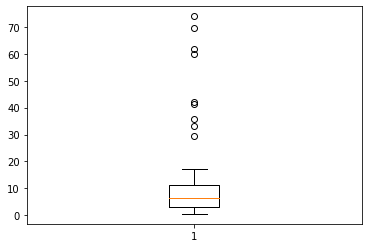

In [30]:
config = [7, 32, 50, 50]

train_model(dir_path, 90, config)

#### Observations
---

The following are the observations from the RMSE scores post training and testing on different datasets, each denoting a different user type:
 - The average RMSE is around 14.5.
 - The highest RMSE is around 89.9, which still denotes that even for the worse test results, the information loss isn't a lot in the MLP model.
 - The model takes in historic data for 7 days to generate predicted data consumption for the 8th day.
 - The performance of the model can be further improved with architectural changes and hyperparameter optimization, which hasn't been done here since this is just a proof-of-concept model for univariate data.

Finally, let us perform autocorrelation on the merged data. 

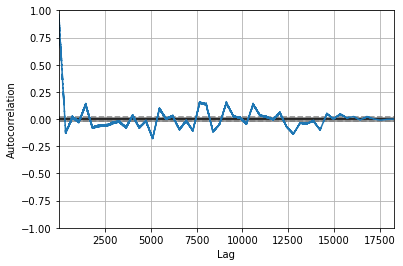

In [31]:
from pandas.plotting import autocorrelation_plot

df = pd.read_csv('D:\HPE_CTY\data\merged\merged_data.csv', header=0, parse_dates=[0])
autocorrelation_plot(df.daily_usage)
plt.show()

### 2. ARIMA Model
---

In this section, we are going to train an ARIMA model for our data and evaluate its performance.

For an example, first we are just going to train the ARIMA model for one dataset file and see how it fares.

                               SARIMAX Results                                
Dep. Variable:            daily_usage   No. Observations:                  365
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -1656.515
Date:                Tue, 12 Jul 2022   AIC                           3325.030
Time:                        15:24:53   BIC                           3348.413
Sample:                    01-01-2021   HQIC                          3334.324
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3355      0.040     -8.431      0.000      -0.414      -0.258
ar.L2         -0.3675      0.041     -9.025      0.000      -0.447      -0.288
ar.L3         -0.1775      0.046     -3.849      0.0

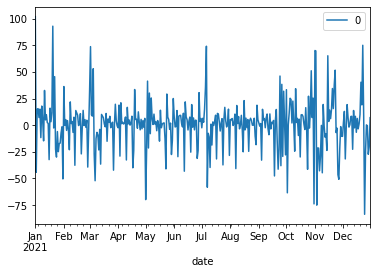

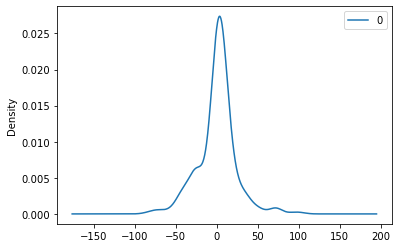

                0
count  365.000000
mean     0.451405
std     23.535921
min    -83.672159
25%     -6.695487
50%      2.119946
75%      9.292260
max    101.982124


In [32]:
from statsmodels.tsa.arima.model import ARIMA

df = pd.read_csv(r"D:\HPE_CTY\data\cust01.csv", header=0, parse_dates=[0], index_col=0)
df.index = df.index.to_period('D')

series = df.daily_usage
# fit model
model = ARIMA(series, order=(5,1,0))   #5 din ka data historical data, shift by 1
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')           #normalised plot
plt.show()
# summary stats of residuals
print(residuals.describe())

Now, let us train our ARIMA model on all the datasets.

In [33]:
def load_and_process_csv(file_path):
    """Function to load data files and process them for model training.
    
    Args-
        file_path: String denoting file path
    
    Returns-
        data: Pandas series object denoting data
    """
    df = pd.read_csv(file_path, header=0, parse_dates=[0], index_col=0)
    df.index = df.index.to_period('D')
    series = df.daily_usage
    return series

In [34]:
import joblib

def train_arima_model(fitted_model, data_dir):
    """Function to train ARIMA model on all user datasets.
    
    Args-
        fitted_model: ARIMAResutls object (returned after ARIMA(...).fit())
        data_dir: Path to the data directory.
    
    Returns-
        results: ARIMA results
    """
    for file in os.listdir(data_dir):
        file_path = os.path.join(data_dir, file)
        try:
            data = load_and_process_csv(file_path)
        except:
            continue
        fitted_model = fitted_model.apply(data)
    save_dir = r"D:\HPE_CTY\pre_trained_models\ARIMA"
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    joblib.dump(fitted_model, os.path.join(save_dir, "sarima.pkl"))
    return fitted_model

In [35]:
fitted_model = train_arima_model(model_fit, dir_path)

Now that we have trained out ARIMA model, let us test it's performance on a newly generated dataset.

predicted=40.465284, expected=27.574786
predicted=31.605345, expected=39.524048
predicted=40.680962, expected=38.956714
predicted=37.039839, expected=40.163553
predicted=41.074567, expected=39.998773
predicted=38.979241, expected=42.040560
predicted=38.612202, expected=38.710908
predicted=38.878812, expected=26.056478
predicted=30.934270, expected=36.910031
predicted=37.939344, expected=38.687491
predicted=36.868451, expected=36.042140
predicted=38.886324, expected=36.585765
predicted=36.750159, expected=37.704894
predicted=34.564369, expected=36.820405
predicted=36.986668, expected=28.621796
predicted=31.948071, expected=44.150440
predicted=41.650865, expected=41.167824
predicted=37.922362, expected=43.684657
predicted=43.825178, expected=42.856781
predicted=40.008813, expected=38.762110
predicted=37.296730, expected=36.664903
predicted=38.959471, expected=34.306818
predicted=36.260855, expected=42.281548
predicted=42.254467, expected=41.911551
predicted=41.093355, expected=38.218070


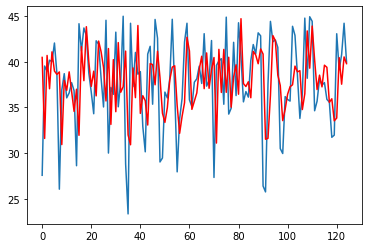

In [76]:
# generating dataset
test_user, test_user_type = generate_data_values(65, 70, 365) 
generate_dataset(user2, date, user_type_2, "test_cust01.csv", dir_path) # increase counter in file name by 1 before running

# loading dataset
df = pd.read_csv(r"D:\HPE_CTY\data\test_cust01.csv", header=0, parse_dates=[0], index_col=0)
df.index = df.index.to_period('D')
series = df.daily_usage
X = series.values

# splitting into test-train splits 
size = int(len(X) * 0.66)
train_data, test_data = X[0:size], X[size:len(X)]
history = [x for x in train_data]
predictions = list()
# walk-forward validation
for t in range(len(test_data)):
    fitted_model = fitted_model.apply(history)
    output = fitted_model.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_data[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test_data, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test_data)
plt.plot(predictions, color='red')
plt.show()

In [79]:
model = joblib.load(r"D:\HPE_CTY\pre_trained_models\ARIMA\sarima.pkl")
output = model.forecast()
output

2022-01-01    33.642756
Freq: D, dtype: float64

#### Observations
---

The following are the observations from the RMSE score post training and testing on the ARIMA model:
 - The test RMSE came out to be 5.93, which is significantly lower than the average RMSE of the MLP model.
 - For this model, the date was also factored in as a dependent variable, which means that unlike the MLP model, this model is time-variant. Thus factors like low sale periods or high sale periods of a business can affect the total data consumption of the SaaS user.
 - The graph, comparing the ground truth to the predicted data clearly shows that the model is very accurate, and is generalized in terms of the data it can perform inference on.

### 3. LSTM Model
---

In this section, we are going to train an LSTM model, belonging to the category of memory-cell based data models, and evaluate its performance. It is generally seen that LSTMs tend to perform better than regular RNNs when it comes to memory-based data modeling.

In [37]:
from keras.layers import LSTM

def get_or_create_lstm_model(model_path=None, config=None):
    """Function to get or create
    """
    try:
        model = load_model(model_path)
    except:
        n_input, n_nodes, _, _ = config
        model = Sequential()
        model.add(LSTM(n_nodes, activation='relu', input_shape=(n_input, 1)))
        model.add(Dense(n_nodes, activation='relu'))
        model.add(Dense(1))
        model.compile(loss='mse', optimizer='adam') 
    return model

In [38]:
def model_fit_lstm(model, train_data, config):
    """Util function to train a model on training data.
    
    Args-
        train_data: Training data
        config: Hyperparam config values array
        model: Pre-trained model
    Returns-
        model: Trained model 
    """
    n_input, _, n_epochs, n_batch = config
    # prepare data
    data = convert_series_to_supervised(train_data, n_in=n_input) 
    train_x, train_y = data[:, :-1], data[:, -1]
	# fit
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    save_model(model, "LSTM", r"D:\HPE_CTY\pre_trained_models")
    return model

In [39]:
def walk_forward_validation_lstm(data, n_test, cfg):
    """Function to generate walk-forward validation for univariate data.

    Args-
        data: Data array
        n_test: Number of test instances
        cfg: Config array

    Returns-
        error: RMSE error
    """
    predictions = list()
	# split dataset
    train_data, test_data = train_test_split(data, n_test)
    # get or create model
    model = get_or_create_lstm_model(r"D:\HPE\pre_trained_models\LSTM", cfg)
	# fit model
    model = model_fit_lstm(model, train_data, cfg)
	# seed history with training dataset
    history = [x for x in train_data]
	# step over each time-step in the test set
    for i in range(len(test_data)):
		# fit model and make forecast for history
        yhat = model_predict(model, history, cfg)
		# store forecast in list of predictions
        predictions.append(yhat)
		# add actual observation to history for the next loop
        history.append(test_data[i])
	# estimate prediction error
    error = measure_rmse(test_data, predictions)
    print(' > %.3f' % error)
    return error

### Training the Model
---

In [41]:
def train_model_lstm(data_dir, n_test, config):
    """Function to train the model.
    
    Args-
        data_dir: Directory with individual datasets.
        n_test: Number of test instances
        config: Cofig directory

    Returns-
        None
    """
    error_list = list()
    for file in os.listdir(data_dir):
        try:
            df = pd.read_csv(os.path.join(dir_path, file))
            data = df.daily_usage.to_numpy()
            error = walk_forward_validation_lstm(data, n_test, config)
            print(error)
            error_list.append(error)
        except:
            continue
    summarize_scores("MLP", error_list)

INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


 > 28.730
28.730150655767762
INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


 > 4.713
4.712714910469595
INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


 > 2.142
2.142268199581669
INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


 > 1.930
1.9298422399832054
INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


 > 3.319
3.3189503877276545
INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


 > 5.768
5.768043611535482
INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


 > 1.823
1.8232414492487532
INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


 > 5.103
5.103344773377654
INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


 > 36.593
36.593240914322855
INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


 > 15.209
15.209437057983175
INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


 > 5.864
5.863963838924209
INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


 > 3.746
3.7464206503143633
INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


 > 40.395
40.39547055618058
INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


 > 1.852
1.8521885599158803
INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


 > 7.896
7.895906958205245
INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


 > 58.580
58.579615530792935
INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


 > 3.984
3.9844740538599215
INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


 > 4.926
4.926409337424866
INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


 > 0.543
0.5425833295643238
INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


 > 4.116
4.11636962399169
INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


 > 51.479
51.47944765801772
INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


 > 3.088
3.0883146434626148
INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


 > 5.648
5.647735446329283
INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


 > 2.786
2.7860176682125735
INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


 > 9.084
9.083925600343095
INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


 > 4.843
4.843376854061458
INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


 > 1.936
1.9355511101302407
INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


 > 3.555
3.5548485053253307
INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


 > 8.057
8.057050068630325
INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


 > 1.661
1.6608590090027853
INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


 > 14.308
14.308352021049794
INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


 > 4.933
4.93334659788818
INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


 > 1.977
1.9766154148851778
INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


 > 4.859
4.859464043700908
INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


 > 5.262
5.262449973120076
INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


 > 2.338
2.3381543468567307
INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


 > 8.170
8.169992701119979
INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


 > 63.681
63.68073905359688
INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


 > 1.880
1.8801699172503727
INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


 > 54.279
54.2786686549132
INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


 > 7.543
7.543421490223723
INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


 > 25.356
25.35555044011341
INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


 > 8.418
8.418496855626637
INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


 > 3.923
3.923230485411834
INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


 > 1.783
1.783172419454954
INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


 > 35.087
35.0870482766479
INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


 > 4.829
4.828825869477729
INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


 > 1.999
1.9991098922218948
INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


 > 5.855
5.855451794084088
INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


INFO:tensorflow:Assets written to: D:\HPE_CTY\pre_trained_models\LSTM\assets


 > 4.651
4.650788583145853
MLP: 11.810096240669532 RMSE (+/- 16.195930041823715)


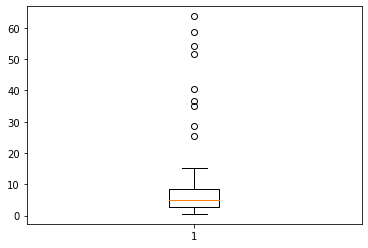

In [42]:
config = [7, 32, 50, 50]

train_model_lstm(dir_path, 90, config)

In [4]:
model = load_model(os.path.join(os.getcwd(), "pre_trained_models", "LSTM"))

Now that we have trained out LSTM model, let us test it's performance on a newly generated dataset.

In [ ]:
# generating dataset
test_user, test_user_type = generate_data_values(70, 75, 365) 
generate_dataset(user2, date, user_type_2, "test_cust02.csv", dir_path) # increase counter in file name by 1 before running

# loading dataset
df = pd.read_csv(r"D:\HPE_CTY\data\test_cust02.csv", header=0, parse_dates=[0], index_col=0)
df.index = df.index.to_period('D')
series = df.daily_usage
X = series.values

# splitting into test-train splits 
size = int(len(X) * 0.66)
train_data, test_data = X[0:size], X[size:len(X)]
history = [x for x in train_data]
predictions = list()
# walk-forward validation
for t in range(len(test_data)):
    fitted_model = fitted_model.apply(history)
    output = fitted_model.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_data[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test_data, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test_data)
plt.plot(predictions, color='red')
plt.show()

#### Observations
---

The following are the observations from the RMSE scores post training and testing on different datasets, each denoting a different user type:
 - The average RMSE is around 11.79.
 - The highest RMSE is around 63.68, which still denotes that even for the worse test results, the information loss isn't a lot in the LSTM model. 
 - In fact, both the average and highest RMSE scores observed in the case of LSTM model are lower as compared to that of the MLP model.
 - The model takes in historic data for 7 days to generate predicted data consumption for the 8th day.
 - The performance of the model can be further improved with architectural changes and hyperparameter optimization.

### 4. Auto-ARIMA Model
---

In this section, we are going to train an Auto-ARIMA model. This also belongs to the category of ARIMA model. For this particular model architecture, we will be training a non-seasonal model. 

Let us begin by importing the necessary modules.

In [7]:
from pmdarima.arima import auto_arima

Let us now import the dataset that we are going to train the model on for testing purposes. One thing that is to be noted here is that ARIMA classes of models take a dataset to train on and then uses the ingested data to generate predictions. Hence, this category of models is not ideal for a production environment.

In [12]:
def prepare_arima_data(path, n_test):
    """Function to prepare data for ARIMA training and testing.
    Args-
        path- String denoting path to the csv file.
        n_test- Integer denoting the number of test instances.
    Returns-
        train_data- pandas.Series denoting training data
        test_data- pandas.Series denoting testing data
    """
    df = pd.read_csv(path, header=0, parse_dates=[0], index_col=0)
    train_data, test_data = train_test_split(df, n_test)
    
    return train_data.daily_usage, test_data.daily_usage

path = r"D:\HPE_CTY\data\cust01.csv"

train_data, test_data = prepare_arima_data(path=path, n_test=65)

We will now train the model and generate a model summary to see how our model is performing.

In [23]:
autoarima_model = auto_arima(train_data, seasonal=True)
autoarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  300
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -1321.662
Date:                Tue, 12 Jul 2022   AIC                           2649.324
Time:                        15:13:35   BIC                           2660.435
Sample:                             0   HQIC                          2653.770
                                - 300                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     64.2997      5.219     12.321      0.000      54.071      74.528
ar.L1          0.4507      0.041     10.875      0.000       0.369       0.532
sigma2       393.1631     19.210     20.467      0.000     355.513     430.813
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):               239.83
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):               0.63   Skew:                             0.10
Prob(H) (two-sided):                  0.02   Kurtosis:                         7.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Now, let us compare the performance of the model.

In [95]:
dir_path = r"D:\HPE_CTY\data"
test_user, test_user_type = generate_data_values(70, 75, 730) 
date = generate_date("2021-01-01", 730)
generate_dataset(test_user, date, test_user_type, "test_cust03.csv", dir_path) # increase counter in file name by 1 before running

In [96]:
df = pd.read_csv(r"D:\HPE_CTY\data\test_cust03.csv")
data_list = df.daily_usage
autoarima_model = auto_arima(data_list[:700], seasonal=True)

In [99]:
predicted_data = autoarima_model.predict(n_periods=30)
actual_data = data_list[700:]

In [102]:
rmse = sqrt(mean_squared_error(actual_data, predicted_data))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.549


#### Observations
---

The following are the observations from the RMSE scores post training and testing on different datasets, each denoting a different user type:
 - The average RMSE is around 1.549. 
 - The test RMSE of auto-ARIMA model is the lowest as compared to all other models.
 - Since we have to re-train a new model for every prediction, the model takes around 1-2 years of historic data to first train and then      generate predictions.
